<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# Base Classifier

by Fabian Märki

## Summary
The aim of this notebook is to train a *Base Classifier* using TF-IDF and a standard ML classifier with default hyperparameters. This builds a *base line* upon which more advanced models (i.e. deep learning ones) should show better performance in order to be considered. Additionally, it also investigate the how much individual features (i.e. words) contribute to the class assignment (feature importance) in order to get an idea if the classifier makes *reasonable* decisions.

In a second step, this notebook uses hyperparameter tuning to automatically improve the performance of the Base Classifier.

This notebook contains assigments: <font color='red'>Questions are written in red.</font>

<a href="https://colab.research.google.com/github/markif/2024_HS_DAS_NLP_Notebooks/blob/master/02_b_Base_Classifier_for_Prototyping.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'

from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import load_dataframe

import pandas as pd
import numpy as np

In [2]:
from fhnw.nlp.utils.system import set_log_level
from fhnw.nlp.utils.system import system_info

set_log_level()
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 5.15.0-46-generic
Python version: 3.6.9
CPU cores: 6
RAM: 31.12GB total and 18.47GB available
Tensorflow version: 2.5.1
GPU is available
GPU is a NVIDIA GeForce RTX 2070 with Max-Q Design with 8192MiB


In [3]:
%%time
download("https://drive.switch.ch/index.php/s/PrVg8Ugfc2jDwT3/download", "data/german_doctor_reviews_original.parq")
data = load_dataframe("data/german_doctor_reviews_original.parq")
data.shape

CPU times: user 874 ms, sys: 134 ms, total: 1.01 s
Wall time: 1.02 s


(357899, 2)

In [4]:
data.head(3)

,text_original,rating
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0


The classification should recognize if a comment has a positive or negative sentiment. We already converted good ratings (1-2) into a *positive*, low ratings (5-6) into a *negative* and mid range ratings (3-4) into a *neutral* label. Here we additionally exclude *neutral* ratings so that the task becomes a binary classification.

In [5]:
data["label"] = "positive"
data.loc[data["rating"] >= 3, "label"] = "neutral"
data.loc[data["rating"] >= 5, "label"] = "negative"

data["sentiment"] = data["label"].apply(lambda x: 1 if x == "positive" else (-1 if x == "negative" else 0))
data = data.astype({"sentiment": "int32"})

# remove all neutral sentimens
data = data.loc[(data["label"] != "neutral")]
# remove all nan
data = data.dropna()

data.shape

(331338, 4)

In [6]:
data.head(3)

,text_original,rating,label,sentiment
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,positive,1
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,negative,-1
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,positive,1


Let's preprocess the text first (text cleaning, tokenization, compound word splitting, stemming, stop word removal). See also [cleaning](https://github.com/markif/2023_FS_CAS_NLP_LAB_Notebooks/blob/master/02_a_Text_Cleaning.ipynb) and [preprocessing](https://github.com/markif/2023_FS_CAS_NLP_LAB_Notebooks/blob/master/02_b_Text_Normalization.ipynb) the doctor reviews dataset for more details.

In [7]:
from nltk.corpus import stopwords

import nltk
nltk.download('punkt')
nltk.download('stopwords')

stopwords = set(stopwords.words("german"))

# analyze and revise stopwords
# add semantically empty words (in the given context)
stopwords.add("frau")
stopwords.add("dr")
stopwords.add("herr")
stopwords.add("herrn")
stopwords.add("fr")
stopwords.add("werden")

# remove semantically meaningful words (like e.g. nicht)
stopwords.remove("nicht")
stopwords.remove("kein")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from fhnw.nlp.utils.preprocess import preprocess

preprocess("Dies ist ein schlechter Arzt.", stopwords=stopwords, do_compound_word_split=True)

['schlecht', 'arzt']

In [9]:
data.head(3)

,text_original,rating,label,sentiment
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,positive,1
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,negative,-1
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,positive,1


Check if dataset is unbalanced. 

In [10]:
val_counts = data["label"].value_counts().sort_index()
val_counts

negative     33028
positive    298310
Name: label, dtype: int64

negative    0.099681
positive    0.900319
Name: label, dtype: float64


<AxesSubplot:>

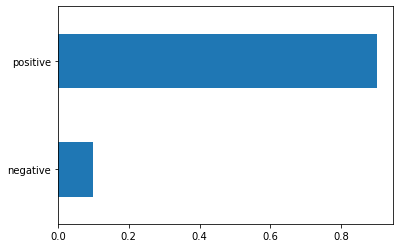

In [11]:
val_counts = val_counts / np.sum(val_counts)
print(val_counts)
val_counts.plot(kind='barh')

It seems the classes are quite unbalanced. 

Models often have difficluties to predict the minor class (in our case, a model that simply predicts the major class already has an accurracy of 90 percent). Methods to deal with unbalanced classes are over- and under-sampling, weighing of classes, data augmentation [etc](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/). It turnes out that the classifier works quite good since the minority class already has quite some of observations (even though there are still some improvements possible as we will see later).

### Base Classifier

Prepare the data (train/test split).

<font color='red'>**TASK: Have a look at *[Visualizing cross-validation behavior](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)* and think about a good way to split the data into training and test sets (the link also deals with [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) - here only the part about [train/test split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) is of importance).**</font>

In [12]:
from sklearn.model_selection import train_test_split

# TODO: !!! place your code here !!!
####################################
# !!! this needs rework !!!
data_train = data[:165594]
data_test = data[165594:]

# ensure we retain the class weights by using stratify
# define random_state to have the same splits among different runs

###################
# TODO: !!! end !!!

In [13]:
X_train, y_train = data_train["text_original"], data_train["label"]
X_test, y_test = data_test["text_original"], data_test["label"]

All default values without hyperparameter optimization.

<font color='red'>**TASK: Build a Classifier using scikit-learn's [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) with [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) and [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html).**</font>

<font color='red'>**Optional: In a later iteration you might want to try different [Classifiers](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py) ([Choosing the Right Estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) could also be of interest).**</font>

In [14]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from fhnw.nlp.utils.preprocess import preprocess

def analyze(text):
    return preprocess(text, stopwords=stopwords, do_compound_word_split=True)


# TODO: !!! place your code here !!!
####################################
pipe = Pipeline([
         ...
        ])

###################
# TODO: !!! end !!!

pipe.fit(X_train, y_train)

CPU times: user 3min 56s, sys: 373 ms, total: 3min 57s
Wall time: 3min 57s


Pipeline(steps=[('vec',
                 TfidfVectorizer(analyzer=<function analyze at 0x7f16ea2d87b8>)),
                ('clf', SGDClassifier(n_jobs=6))])

In [15]:
%%time

y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

CPU times: user 5min 8s, sys: 224 ms, total: 5min 8s
Wall time: 5min 8s


See [here](https://www.youtube.com/watch?v=qWfzIYCvBqo) for a nice explanation of precision and recall.

See [here](https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f) on how to interpret a classification report (and on which measure to choose to compare the performance of different models). 

In [16]:
from sklearn.metrics import classification_report

report = classification_report(y_train, y_train_pred)
print("Train:")
print(report)
report = classification_report(y_test, y_test_pred)
print("Test:")
print(report)

Train:
              precision    recall  f1-score   support

    negative       0.91      0.71      0.80     24771
    positive       0.97      0.99      0.98    223732

    accuracy                           0.96    248503
   macro avg       0.94      0.85      0.89    248503
weighted avg       0.96      0.96      0.96    248503

Test:
              precision    recall  f1-score   support

    negative       0.90      0.69      0.78      8257
    positive       0.97      0.99      0.98     74578

    accuracy                           0.96     82835
   macro avg       0.94      0.84      0.88     82835
weighted avg       0.96      0.96      0.96     82835



See [here](https://www.youtube.com/watch?v=_cpiuMuFj3U) for a nice explanation on how to interprete a confusion matrix.

Set Population: 248503
Accuracy: 0.9639


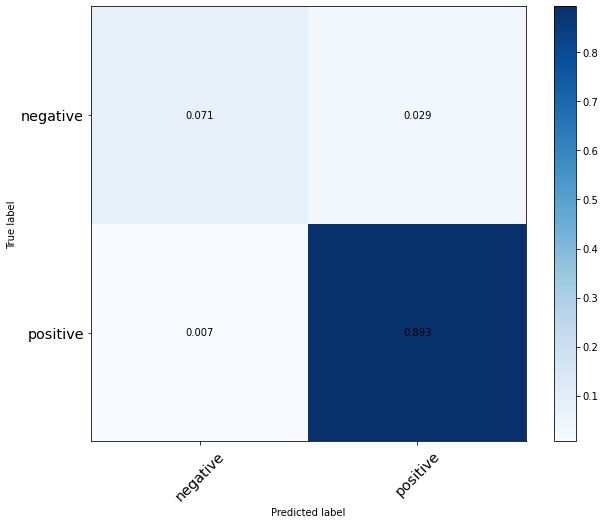

Set Population: 82835
Accuracy: 0.9620


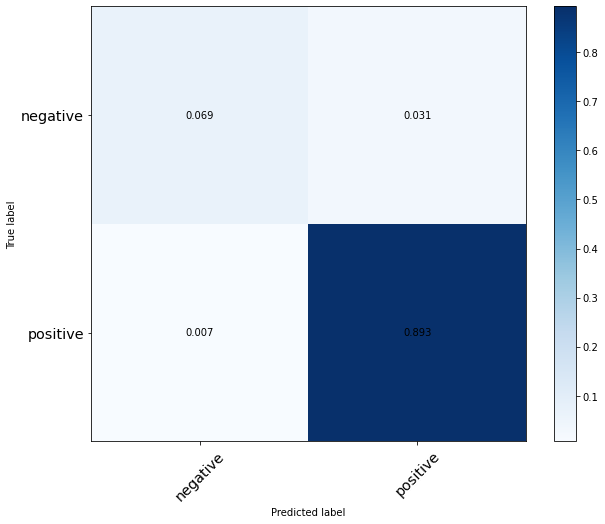

In [17]:
from fhnw.nlp.utils.ploting import plot_confusion_matrix

plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

Check feature importance in order to get an idea if the class assignment builds on reasonable words. 

We can do this because SGDClassifier uses a LinearSVC by default. Recall that a linear SVM creates a hyperplane that uses support vectors to maximise the distance between the two classes. The weights obtained from svm.coef_ represent the vector coordinates which are orthogonal to the hyperplane and their direction indicates the predicted class. The absolute size of the coefficients in relation to each other can then be used to determine feature importance.

See also https://aneesha.medium.com/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

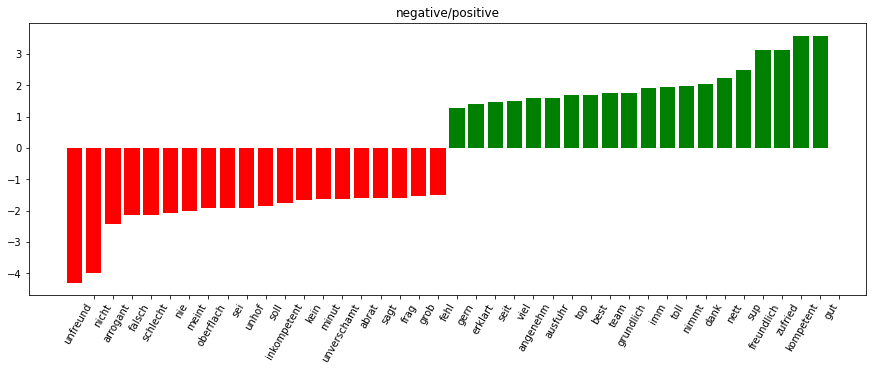

In [18]:
from fhnw.nlp.utils.ploting import plot_feature_importance

vectorizer = pipe.named_steps["vec"]
# only works since SGDClassifier uses LinearSVC by default
classifier = pipe.named_steps["clf"]

plot_feature_importance(classifier, vectorizer.get_feature_names_out())

Get an impression on texts with wrong prediction.

In [19]:
pd.set_option('display.max_colwidth', None)

data_train["prediction"] = y_train_pred

data_train[data_train["label"] != data_train["prediction"]][["text_original", "label", "prediction"]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,text_original,label,prediction
95574,"Ich bin nur noch aus einem Grund in diese Praxis gegangen. Dr. Dudek war eigentlich immer sehr hilfreich, wenn er mal da war. Ich hatte auch oft seine Vertretung die einen mal schnell mit ein paar Tropfen wieder weg geschickt hat. Die Sprechstundenhilfen sind wirklich alle unfreundlich und schroff. Es kommt nie ein freundliches Guten Morgen. Da hat man einen Termin online gemacht aber die Damen hatten ihr System noch nicht upgedatet, bekommt man sofort eine richtig freche Antwort. Wenn man etwas will, hat man da vorne sofort verloren. Die scheinen mir da vorne nicht sehr arbeitswillig zu sein. Nach meinen letzten Erlebnis, wo ich telefonisch sehr angegangen wurde, war das nun mein letztes Mal in dieser Praxis! Beruf verfehlt, Patienten egal. Man muss erstmal an den Wachhunden versuchen vorbei zu kommen bis man mal behandelt wird.",positive,negative
220265,"Herr Dr. Kremer ordnet Untersuchungen an, ohne den Patienten darüber zu informieren. Ich sollte einen Termin für eine bestimmte Untersuchung durch seine Helferin bekommen, den ich ablehnte, da ich der Meinung war, dass diese Untersuchung absolut nichts mit meinen Beschwerden zu tun hatte.<br />\r\nPrivatpatienten werden immer wieder bestellt.<br />\r\nDie Rechnungen sind sehr hoch. Ich weiß es aus Fällen in meiner Bekanntschaft,; auch meine Hausärztin hat mich darüber informiert.",negative,positive
23538,"Zunächst das Positive: Kurze Wartezeit beim Termin. Ende<br />\nDas Negative: <br />\nWenig Interesse am Patienten und dessen Beschwerden, ""Ihnen geht es doch gut""!<br />\nSprechstundenhilfe äußerst sich herablassend über andere Patienten.<br />\nEs gibt keine Hinterfragung der Ergebnisse von Vorbehandlungen.<br />\nEs werden Symptohme festgestellt, diese aber nicht erklärt oder in einen Zusammenhang gestellt.<br />\nMan fühlt sich nicht als Paitent wahr genommen, ""Irgendjemand wird das schon bezahlen, ich weiß nicht wer aber jemand sicherlich.""",negative,positive
264798,Meine Tochter musste heute wegen eines Auslandsaufenthaltes geimpft werden. Dabei wurde ihre ohne vorherige Frage eine HPV-Impfung verpasst. Das hat ein Nachspiel!,negative,positive
316668,"Total überlastetes, und anscheinend unterbezahltes Arzthelferinnen-Personal !",negative,positive
...,...,...,...
242309,Bitte bei der Medikamenten Verschreibung doch gleich ein Hinweis auf Einnahmezeiten schriftlich mitgeben ich war leider überfordert bei 3 MedikamentenEinnahmen jedenfalls Stunden später wusste ich nicht mehr genau wie und wann ich die Medikamente nehmen sollte,positive,negative
23872,Ärztin will eine schnell weghaben aufgrund der vollen Praxis. Alles kurz und knapp und das allermindeste .,negative,positive
53785,"wie so viele Orthopäden wird auch Dr. nasseri dem schlechten ruf seiner Kollegen vollstens gerecht.<br />\nIch kann diese Praxis absolut nicht empfehlen.<br />\nNettigkeit ist kein Qualitätsmerkmal , sonder wie ernst werde ich genommen, hört man mir zu und welche therapieempfehlungen bekomme ich.",negative,positive
341541,"Die Bewertung eines Arztes erfolgt nicht danach, wie breit er lächelt, sondern, wie er einem hilft!<br />\nDr. Weihe verweigerte eine Behandlung mir Aclasta-Infusion, die meine Osteoporosewerte bei der Behandlung beim Kölner Arzt ü. 4 Jahre, deutlich verbessert hatte.<br />\nAls normaler Sterblicher erhielt ich zuerst die billigste Variante, Tabletten, die meinen Magen in einer Woche kaputt gemacht hatten, später andere preisgünstige Alternative. Er sparte an mir. <br />\nEin Wechsel des Arztes brachte Erfolg!",negative,positive


# Hyperparameter Tuning

In case the above results are not good enough, the next step is to tune hyperparameters in order to improve the performance of the Base Classifier. Instead of doing this manually, we automate this laborious process by using a hyperparameter optimization framework. 

There are many tuners available:
- [scikit-learn](https://scikit-learn.org/stable/modules/grid_search.html)
- [scikit-optimize](https://scikit-optimize.github.io/stable/)
- [Optuna](https://optuna.readthedocs.io/en/stable/)
- [KerasTuner](https://keras.io/keras_tuner/)
- [Ax](https://ax.dev)
- ...

During hyperparameter tuning we will need the preprocessed tokens during each iteration. Therefore it makes sense to externalize the preprocessing step (do it once and store the tokens so we can reuse them for each hyperparameter evaluation).

In [20]:
%%time

from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.preprocess import preprocess

data = parallelize_dataframe(data, preprocess, field_read="text_original", field_write="tokens", stopwords=stopwords, do_compound_word_split=True)

CPU times: user 2.69 s, sys: 600 ms, total: 3.29 s
Wall time: 50.5 s


Let's give optuna a try (see [here](https://github.com/markif/2024_HS_CAS_NLP_LAB_Notebooks/blob/master/03_b_Base_Classifier_with_Hyperparameter_Tuning.ipynb) in case you are interested in scikit-optimize)

In [21]:
%%capture

#!pip install optuna
!pip install --pre optuna

In [22]:
import optuna

print(optuna.__version__)

3.0.0rc0


In [23]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, shuffle=True, random_state=42, stratify=data["label"])

X_train, y_train = data_train["tokens"], data_train["label"]
X_test, y_test = data_test["tokens"], data_test["label"]

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from fhnw.nlp.utils.processing import identity

pipe = Pipeline([
         ("vec", TfidfVectorizer(tokenizer=identity, preprocessor=identity, stop_words=None)),
         ("clf", SGDClassifier())
        ])

<font color='red'>**TASK: Select a set of hyperparameter and perform an optimization.**</font>

Useful Videos (you might want to watch them first):
- [Hyperparameter Tuning Process](https://www.youtube.com/watch?v=AXDByU3D1hA)
- [Appropriate Scale to Pick Hyperparameters](https://www.youtube.com/watch?v=cSoK_6Rkbfg)

Possible Inspirations:
- Parameters of [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) and [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [Hyperparameter Optimization with Optuna](https://www.datasciencebyexample.com/2022/07/02/2022-07-02-1/)

Further Links:
- [Hyperparameter Tuning](https://neptune.ai/blog/hyperparameter-tuning-in-python-a-complete-guide-2020)
- [Reasons for Cross Validation](https://towardsdatascience.com/5-reasons-why-you-should-use-cross-validation-in-your-data-science-project-8163311a1e79)
- [Model Evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html) (also on how to evaluate [imbalanced classes/datasets](https://scikit-learn.org/stable/modules/model_evaluation.html#from-binary-to-multiclass-and-multilabel))
- [Tour of Evaluation Metrics for Imbalanced Classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)
- [Bayesian Optimization](https://en.wikipedia.org/wiki/Bayesian_optimization)
- [Conceptual Explanation of Bayesian Hyperparameter Optimization](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)
- [Exploring Bayesian Optimization](https://distill.pub/2020/bayesian-optimization/)

In [25]:
from sklearn.metrics import f1_score, make_scorer

scoring_function = make_scorer(f1_score, average='weighted')
#scoring_function = make_scorer(f1_score, average='macro')

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

def objective(trial):

    # TODO: !!! place your code here !!!
    ####################################
    params = {
        "clf__alpha": trial.suggest_...,
        ...
    }
    
    ###################
    # TODO: !!! end !!!
    
    # set the hyper parameters to try
    pipe.set_params(**params)

    return np.mean(cross_val_score(
        pipe, 
        X_train, 
        y_train, 
        # Stratified K-Folds cross-validator (with 3 splits/folds)
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), 
        n_jobs=-1, 
        scoring=scoring_function))

In [27]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
#optuna.logging.set_verbosity(optuna.logging.INFO)

import optuna

study = optuna.create_study(
    direction="maximize", 
    #sampler=optuna.samplers.MOTPESampler(),
    #sampler=optuna.samplers.NSGAIISampler(),
    pruner=optuna.pruners.HyperbandPruner(),
)

print(f"Sampler is {study.sampler.__class__.__name__}")
print(f"Pruner is {study.pruner.__class__.__name__}")

[I 2022-08-19 14:57:42,509] A new study created in memory with name: no-name-a5ddc6f7-3a22-43a4-a3ac-86487a55463c


Sampler is TPESampler
Pruner is HyperbandPruner


In [ ]:
%%time

study.optimize(
    objective, 
    n_trials=100, 
)

In [29]:
print(study.best_trial.values)
print(study.best_trial.params)

[0.9760530062996179]
{'vec__max_df': 0.6191282183243669, 'vec__min_df': 0.00011357420295111831, 'vec__ngram_range': (1, 3), 'vec__use_idf': True, 'vec__sublinear_tf': False, 'clf__alpha': 8.560290577248475e-06}


In [30]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [ ]:
plot_optimization_history(study)

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_contour(study)

In [ ]:
plot_slice(study)

In [ ]:
plot_param_importances(study)

In [36]:
pipe.set_params(**study.best_params)
pipe.fit(X_train, y_train)

Pipeline(steps=[('vec',
                 TfidfVectorizer(max_df=0.6191282183243669,
                                 min_df=0.00011357420295111831,
                                 ngram_range=(1, 3),
                                 preprocessor=<function identity at 0x7f4fbd1f8820>,
                                 tokenizer=<function identity at 0x7f4fbd1f8820>)),
                ('clf', SGDClassifier(alpha=8.560290577248475e-06))])

In [37]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [38]:
from sklearn.metrics import classification_report

report = classification_report(y_train, y_train_pred)
print("Train:")
print(report)
report = classification_report(y_test, y_test_pred)
print("Test:")
print(report)

Train:
              precision    recall  f1-score   support

    negative       0.94      0.90      0.92     24771
    positive       0.99      0.99      0.99    223732

    accuracy                           0.98    248503
   macro avg       0.96      0.95      0.95    248503
weighted avg       0.98      0.98      0.98    248503

Test:
              precision    recall  f1-score   support

    negative       0.91      0.85      0.88      8257
    positive       0.98      0.99      0.99     74578

    accuracy                           0.98     82835
   macro avg       0.95      0.92      0.93     82835
weighted avg       0.98      0.98      0.98     82835



In [ ]:
from fhnw.nlp.utils.ploting import plot_confusion_matrix

plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)